In [166]:
import numpy as np
import matplotlib.pylab as plt

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from math import floor

import warnings
warnings.filterwarnings("ignore")

### Constants:

In [24]:
gL = 0.003 * 1e2
gK = 0.36 * 1e2
gNa = 1.2 * 1e2

EL = -54.387
EK = -77
ENa = 50

### Alphas and Betas

In [81]:
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65)) 

def beta_m(V):
    return 4 * np.exp(-0.0556 * (V + 65))

def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))

ALPHAS_BETAS = {
    'n': (alpha_n, beta_n),
    'm': (alpha_m, beta_m),
    'h': (alpha_h, beta_h)
}

### Create simulation

In [371]:
def simulation(num_currents, I_range, T_range, interval, sim_time, num_steps=1e5):
    """
        initialize simulation
        :param num_currents: number of currents that define the Ie
        :param I_range: amperage range
        :param T_range: supply time range
        :param interval: time interval between two current supplies
        :param sim_time: simulation time
        :param num_steps: number of timesteps to consider
        :return: tuple of: Ie(t) function, current_values and timesteps
    """
    
    I_min, I_max = I_range
    T_min, T_max = T_range
    
    # generate random amperage and supply time for each current on a given range
    I_supply = I_min + np.random.sample(size=(num_currents,)) * (I_max - I_min)
    if T_min and T_max:
        T_supply = T_min + np.random.sample(size=(num_currents,)) * (T_max - T_min)
    else:
        T_supply = None
    
    print('currents:', I_supply)
    print('time:    ', T_supply)
    
    timesteps = np.linspace(0, sim_time, num_steps)
    
    if T_supply is not None: # if the supply time for each current is defined
        
        current_starts = [0] * num_currents
        for i in range(1, num_currents): # compute start time for each current
            current_starts[i] = current_starts[i - 1] + T_supply[i - 1] + interval
        print('starts:  ', current_starts)
        
        def get_current_value(ts):
            for current_num, c_start in enumerate(current_starts):
                if ts < c_start:
                    return 0
                if c_start <= ts <= c_start + T_supply[current_num]:
                    return I_supply[current_num]
            return 0
                    
    else: # if the supply time isn't defined there will be a random current at each timestep
        
        values = [0] * (sim_time + 1)
        for i in range(sim_time + 1):
            if i % 2:
                rand_current_idx = np.random.randint(0, num_currents)
                values[i] = I_supply[rand_current_idx]
        def get_current_value(ts):
            t_low = int(floor(ts))
            return values[t_low]
            
    current_values = np.array([get_current_value(ts) for ts in timesteps])
    return get_current_value, current_values, timesteps

### Hodgkin Huxley Model

In [223]:
class HHModel:
    def __init__(self, time_to_current, timesteps, Cm=1):
        """
            :param time_to_current: Ie(t) function
            :param timesteps: timesteps array
        """
        self.time_to_current = time_to_current
        self.timesteps = timesteps
        self.Cm = Cm
        self.init_conditions = (-65, 0.05, 0.6, 0.32)
    
    def dxdt(self, V, x_idx, x):
        """
            :param V: just V...
            :param x_idx: string, either 'n', 'm' or 'h'
            :param x: the value of n, m, or h
            :return: dxdt
        """
        alpha, beta = ALPHAS_BETAS[x_idx]
        return alpha(V) * (1 - x) - beta(V) * x
    
    def dVdt(self, V, timestep, n, m, h):
        Ie = self.time_to_current(timestep)
        K = gK * (n**4) * (V - EK)
        Na = gNa * (m**3) * h * (V - ENa)
        L = gL * (V - EL)
        return 1 / self.Cm * (Ie - (K + Na + L))
    
    def func_to_derivate(self, variables, timestep):
        V, n, m, h = variables
        return [
            self.dVdt(V, timestep, n, m, h),
            self.dxdt(V, 'n', n),
            self.dxdt(V, 'm', m),
            self.dxdt(V, 'h', h)
        ]
    
    def solve(self):
        return odeint(
            func = self.func_to_derivate, 
            y0   = self.init_conditions, 
            t    = self.timesteps
        )

### Visualization

In [319]:
def viz2d(solution, current_values, timesteps):
    V = solution[:, 0]
    x_array = [(solution[:, 1], 'n', 'r'), (solution[:, 2], 'm', 'g'), (solution[:, 3], 'h', 'b')]
    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(timesteps, V)
    ax1.set_ylabel('$V(mV)$', fontsize=14)
    ax1.set_xlabel('$t(ms)$', fontsize=14)
    
    for x in x_array:
        values, label, color = x
        ax2 = plt.subplot(3, 1, 2)
        ax2.plot(timesteps, values, label=label, color=color)
    ax2.set_ylabel('n, m, h', fontsize=14)
    ax2.set_xlabel('$t(ms)$', fontsize=14)
    ax2.legend(loc='lower right')
    
    ax3 = plt.subplot(3, 1, 3)
    ax3.plot(timesteps, current_values)
    ax3.set_ylabel('$i_m({\mu}A / mm^2)$', fontsize=14)
    ax3.set_xlabel('$t(ms)$', fontsize=14)

def viz3d(solution, current_values, timesteps):
    V = solution[:, 0]
    x_array = [(solution[:, 1], 'n', 'r'), (solution[:, 2], 'm', 'g'), (solution[:, 3], 'h', 'b')]
    
    fig = plt.figure(figsize=(18, 6))
    for i, x in enumerate(x_array):
        values, label, color = x
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.plot3D(timesteps, V, values, color=color)
        ax.set_xlabel('$t\ (ms)$', fontsize=14)
        ax.set_ylabel('$V(t)\ (mV)$', fontsize=14)
        ax.set_zlabel('$' + label + '(t)$', fontsize=14)

### Simulation №1  
number of currents: 4  
amperage range: (5, 50) (nA)   
time length range: (20, 100) (ms)  
intervals between current supplies: 50ms  
simulation time: 400ms

In [357]:
time_to_current_1, current_values_1, timesteps_1 = simulation(
    num_currents = 4,
    I_range      = (5, 50),
    T_range      = (20, 100),
    interval     = 50,
    sim_time     = 400
)

currents: [17.63355995  5.18064607 12.79062225 35.87473795]
time:     [87.27997135 77.37055292 87.75610753 28.72229911]
starts:   [0, 137.27997135365564, 264.65052427609373, 402.4066318071704]


In [358]:
model_1 = HHModel(time_to_current_1, timesteps_1)

In [359]:
solution_1 = model_1.solve()

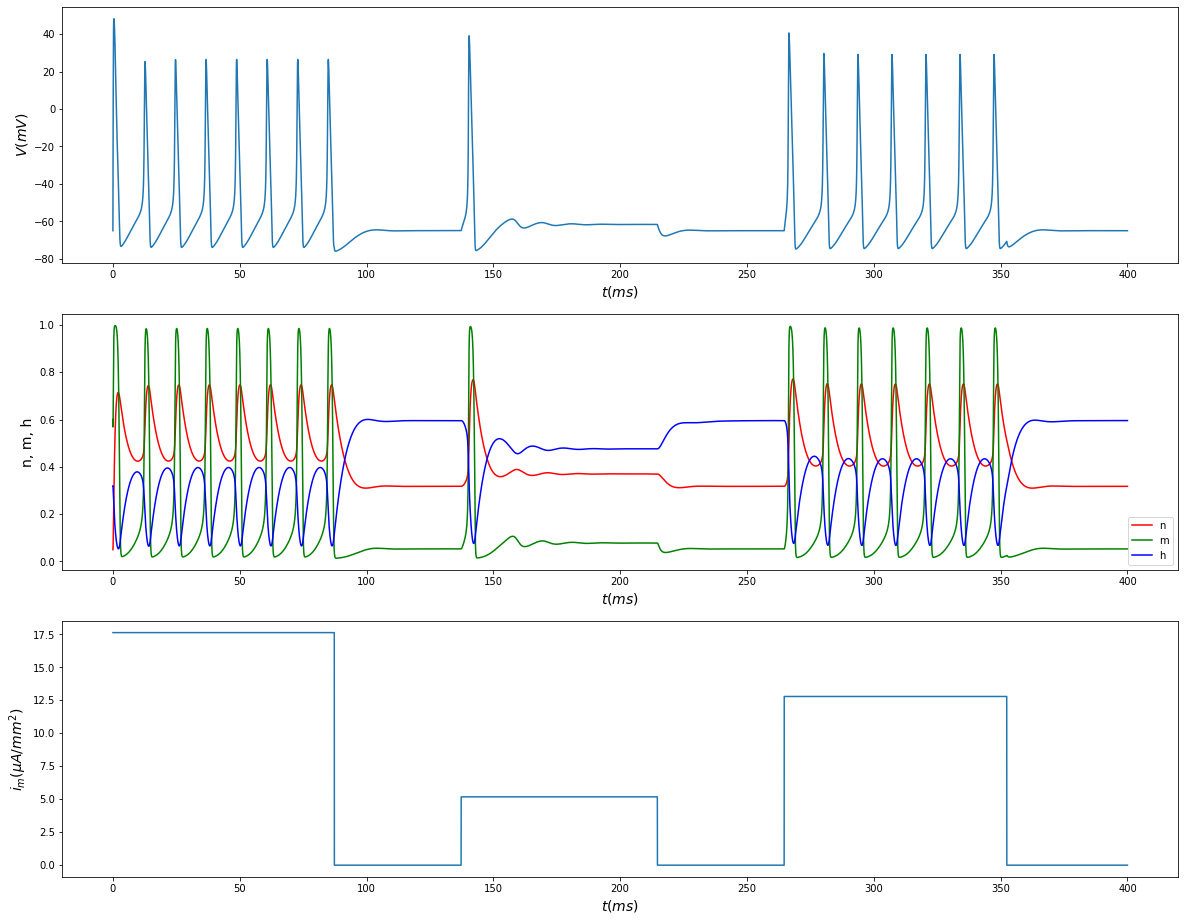

In [362]:
viz2d(solution_1, current_values_1, timesteps_1)

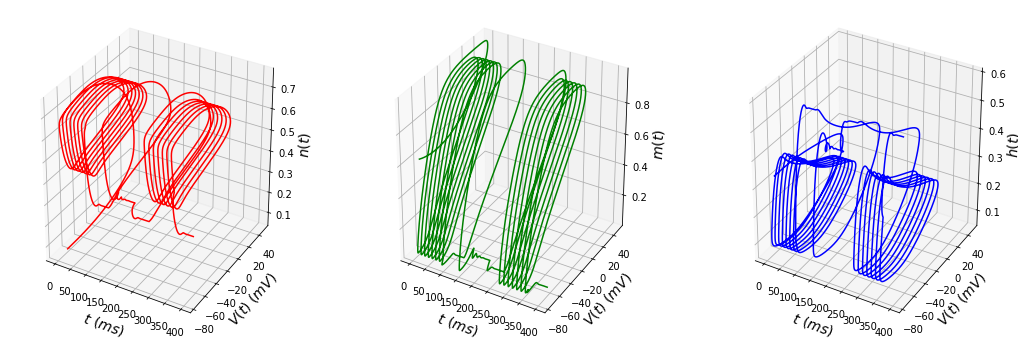

In [361]:
viz3d(solution_1, current_values_1, timesteps_1)

### Выводы  
Про зависимости амплитуды и частоты I и V:  
Чем выше сила тока, тем ниже амплитуда V   
Чем выше сила тока, тем выше частота спайков  
Со временем частота понижается  
При достаточно низкой силе тока стабилизации не происходит  
Из графиков фазовых пространств можно увидеть, что не для каждого промежутка есть предельный цикл. Для промежутка, на котором подавался ток с низким значением предельного цикла нет

### Simulation №2  
number of currents: 2  
amperage range: (50, 200) (nA)   
time length range: (None, None) (ms)  
intervals between current supplies: 1ms  
simulation time: 200ms

In [366]:
time_to_current_2, current_values_2, timesteps_2 = simulation(
    num_currents = 2,
    I_range      = (50, 200),
    T_range      = (None, None),
    interval     = 1,
    sim_time     = 200
)

currents: [185.79826437 102.33494031]
time:     None


In [367]:
model_2 = HHModel(time_to_current_2, timesteps_2)

In [368]:
solution_2 = model_2.solve()

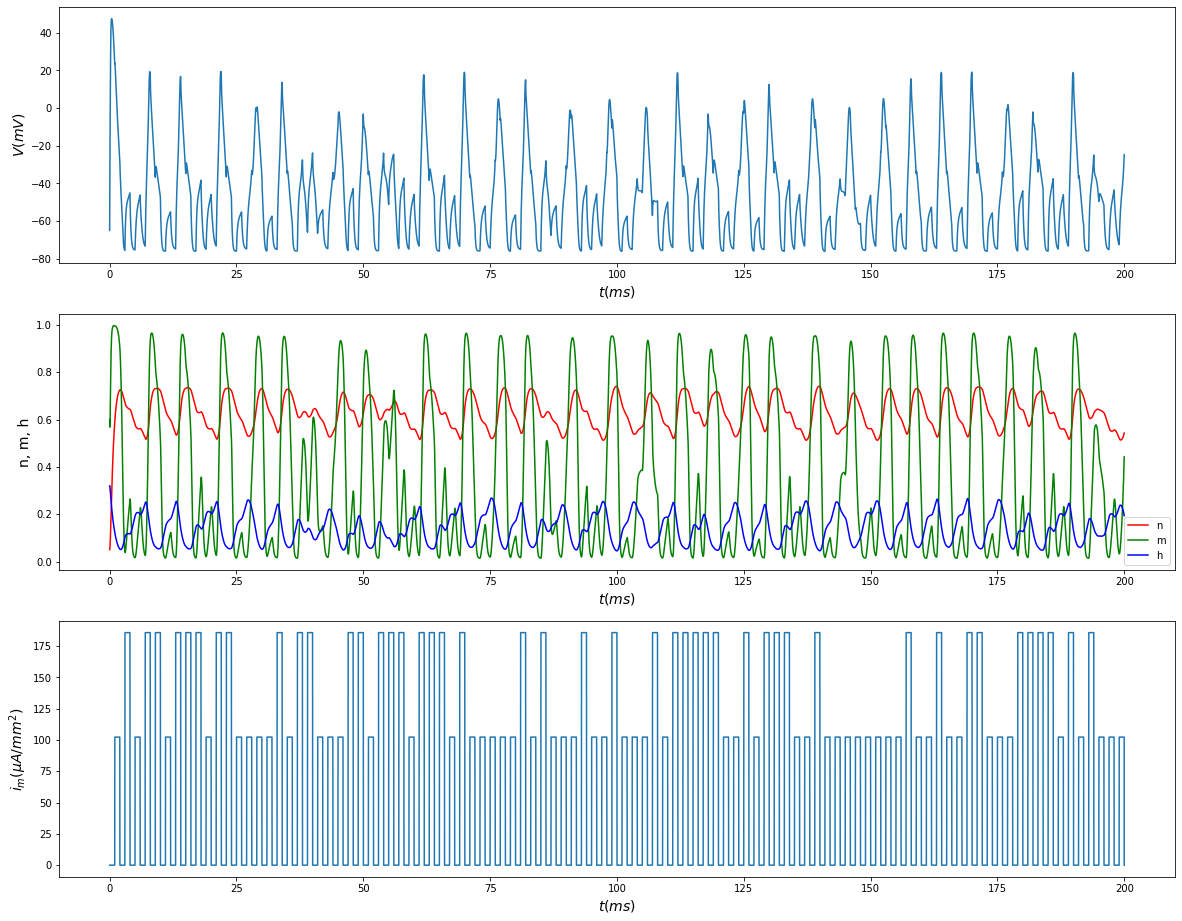

In [369]:
viz2d(solution_2, current_values_2, timesteps_2)

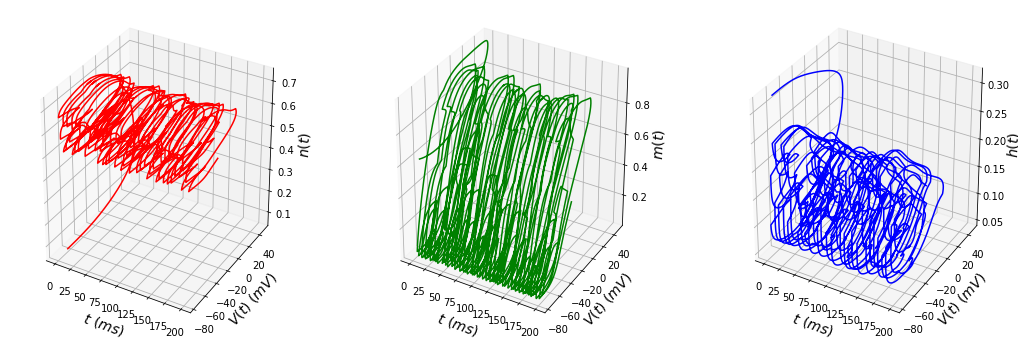

In [370]:
viz3d(solution_2, current_values_2, timesteps_2)

### Выводы  
Поскольку все значения силы тока выше порога, можно наблюдать постоянные спайки.  
Из-за случайности подаваемого тока в спайках не возникает некоторой периодичности